### Пример простой сетки с двумя головами

In [76]:
import timm
import torch
import torch.nn as nn

class Backbone(nn.Module):
    def __init__(self, model_name="efficientnet_b0", out_indices=(-1, -2, -3)):
        super().__init__()
        # timm.list_models(pretrained=True)
        self.backbone = timm.create_model(model_name, pretrained=True, features_only=True, out_indices=out_indices)
        # Выключаем градиенты у модели, чтобы упростить обучение
        for param in self.backbone.parameters():
            param.requires_grad = False

    def forward(self, x):
        return self.backbone(x)


class DetectionHead(nn.Module):
    def __init__(self, in_channels, num_anchors, num_classes):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.cls_head = nn.Conv2d(in_channels, num_anchors * num_classes, kernel_size=1)
        self.reg_head = nn.Conv2d(in_channels, num_anchors * 5, kernel_size=1)
        # В Decoupled head разделяется выход для регрессии и confidence / objectness
        # self.reg_head = nn.Conv2d(in_channels, num_anchors * 4, kernel_size=1)
        # self.obj_head = nn.Conv2d(in_channels, num_anchors, kernel_size=1)
        self.num_classes = num_classes

    def forward(self, x):
        x = F.relu(self.conv(x))
        cls_logits = self.cls_head(x)
        bbox_preds = self.reg_head(x)
        # obj_logits = self.obj_head(x)
        return cls_logits, bbox_preds#, obj_logits


class TwoHeadFPN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.first_fpn_conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.first_act = nn.ReLU()
        self.first_bn = nn.BatchNorm2d(out_channels)

        self.second_fpn_conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.second_act = nn.ReLU()
        self.second_bn = nn.BatchNorm2d(out_channels)

    def forward(self, features):
        first_features = self.first_act(self.first_bn(self.first_fpn_conv(features[0])))
        second_features = self.second_act(self.second_bn(self.second_fpn_conv(features[1])))

### Работа с якорями

In [1]:
from torchvision.models.detection.anchor_utils import AnchorGenerator

Можно посмотреть исходный код [тут](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/anchor_utils.py#L10)

```markdown
__Init signature__: AnchorGenerator(sizes=((128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),))
__Docstring__:     
Module that generates anchors for a set of feature maps and
image sizes.

The module support computing anchors at multiple sizes and aspect ratios
per feature map. This module assumes aspect ratio = height / width for
each anchor.

sizes and aspect_ratios should have the same number of elements, and it should
correspond to the number of feature maps.

sizes[i] and aspect_ratios[i] can have an arbitrary number of elements,
and AnchorGenerator will output a set of sizes[i] * aspect_ratios[i] anchors
per spatial location for feature map i.

!! method assumes aspect ratio = height / width for an anchor.

Args:
    sizes (Tuple[Tuple[int]]):
    aspect_ratios (Tuple[Tuple[float]]):
```

In [66]:
anchor_sizes = ((32, 64), (82, 164))
anchor_ratios = ((1, 2, 4), (0.5, 1, 2)) # Отвечает за соотношение сторон
ag = AnchorGenerator(sizes=anchor_sizes, aspect_ratios=anchor_ratios)

In [67]:
print(f"Сколько якорей будет для каждого выхода сети: {ag.num_anchors_per_location()}")

Сколько якорей будет для каждого выхода сети: [6, 6]


In [121]:
# Базовые координаты якорей
ag.cell_anchors

[tensor([[-16., -16.,  16.,  16.],
         [-32., -32.,  32.,  32.],
         [-11., -23.,  11.,  23.],
         [-23., -45.,  23.,  45.],
         [ -8., -32.,   8.,  32.],
         [-16., -64.,  16.,  64.]]),
 tensor([[ -58.,  -29.,   58.,   29.],
         [-116.,  -58.,  116.,   58.],
         [ -41.,  -41.,   41.,   41.],
         [ -82.,  -82.,   82.,   82.],
         [ -29.,  -58.,   29.,   58.],
         [ -58., -116.,   58.,  116.]])]

In [119]:
ag.cell_anchors[0][:, 2] - ag.cell_anchors[0][:, 0], ag.cell_anchors[0][:, 3] - ag.cell_anchors[0][:, 1]

(tensor([32., 64., 22., 46., 16., 32.]),
 tensor([ 32.,  64.,  46.,  90.,  64., 128.]))

In [129]:
ag.cell_anchors[1][:, 2] - ag.cell_anchors[1][:, 0], ag.cell_anchors[1][:, 3] - ag.cell_anchors[1][:, 1]

(tensor([116., 232.,  82., 164.,  58., 116.]),
 tensor([ 58., 116.,  82., 164., 116., 232.]))

In [96]:
import matplotlib.pyplot as plt
def plot_anchors(cell_anchors, xlims=(-150, 150), ylims=(-150, 150)):
    _, axes = plt.subplots(1, len(cell_anchors), figsize=(18, 6))
    for ix, (ax, anchors_tensor) in enumerate(zip(axes, cell_anchors)):
        ax.plot([])
        for x1, y1, x2, y2 in anchors_tensor:
            rect = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
        ax.grid()
        ax.set_xlim(*xlims)
        ax.set_ylim(*ylims)
        ax.set_title(f"Набор якорей для головы {ix+1}")
    plt.show()

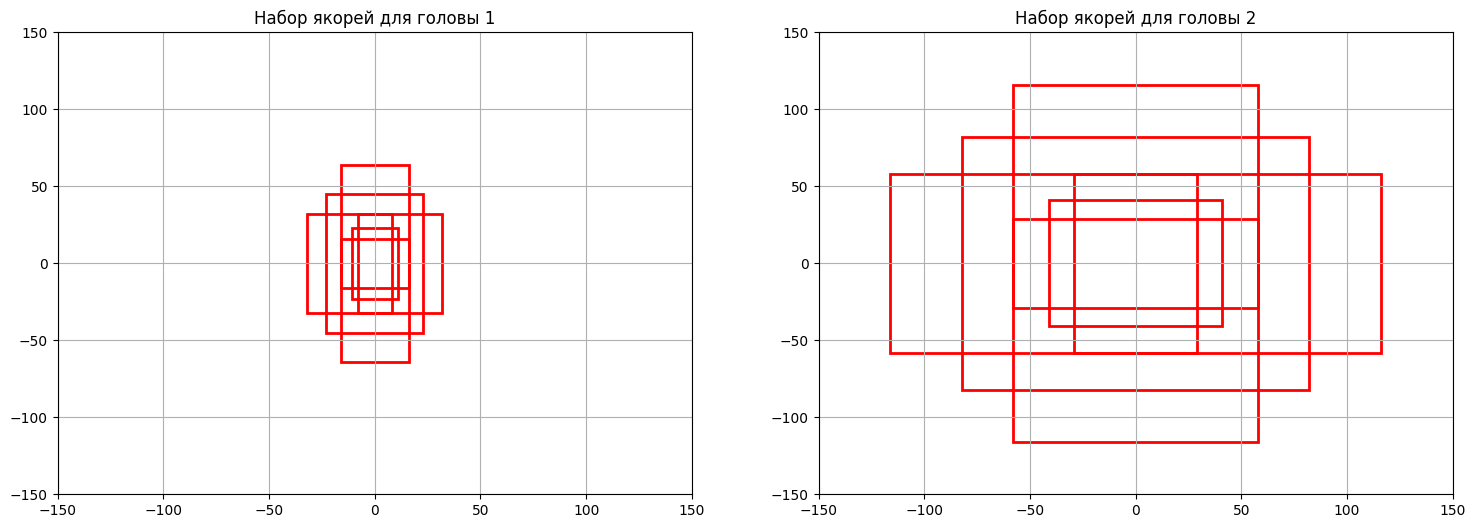

In [97]:
plot_anchors(ag.cell_anchors)

In [77]:
backbone = Backbone(model_name="efficientnet_b0", out_indices=(-1, -2))

Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


In [83]:
reductions = backbone.backbone.feature_info.reduction()[::-1]
print(f"Коэфициент уменьшения исходного изображения для всех выходов: {reductions}")

Коэфициент уменьшения исходного изображения для всех выходов: [16, 32]


In [84]:
input_size = [640, 640]
grid_sizes = [
    [input_size[0] // reduction, input_size[1] // reduction]
    for reduction in reductions
]

print(f"Итоговый размер выходных фичей: {grid_sizes}")

Итоговый размер выходных фичей: [[40, 40], [20, 20]]


In [87]:
strides = [[reduction, reduction] for reduction in reductions]
anchors_grids = ag.grid_anchors(grid_sizes, strides=strides)

In [95]:
anchors_grids

[tensor([[-16., -16.,  16.,  16.],
         [-32., -32.,  32.,  32.],
         [-11., -23.,  11.,  23.],
         ...,
         [601., 579., 647., 669.],
         [616., 592., 632., 656.],
         [608., 560., 640., 688.]]),
 tensor([[ -58.,  -29.,   58.,   29.],
         [-116.,  -58.,  116.,   58.],
         [ -41.,  -41.,   41.,   41.],
         ...,
         [ 526.,  526.,  690.,  690.],
         [ 579.,  550.,  637.,  666.],
         [ 550.,  492.,  666.,  724.]])]

In [103]:
print(f"Общее число якорей для выхода 1: {len(anchors_grids[0])}, Общее число якорей для выхода 2: {len(anchors_grids[1])}")

Общее число якорей для выхода 1: 9600, Общее число якорей для выхода 2: 2400


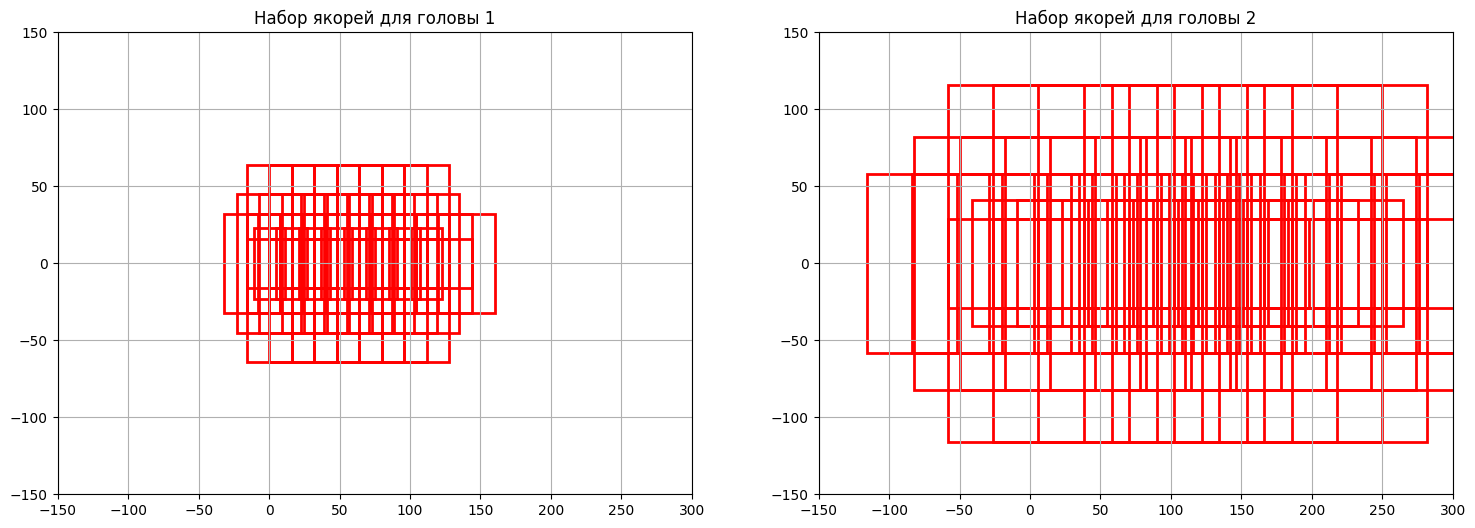

In [107]:
plot_anchors([anchors_grids[0][:50], anchors_grids[1][:50]], xlims=(-150,  300))

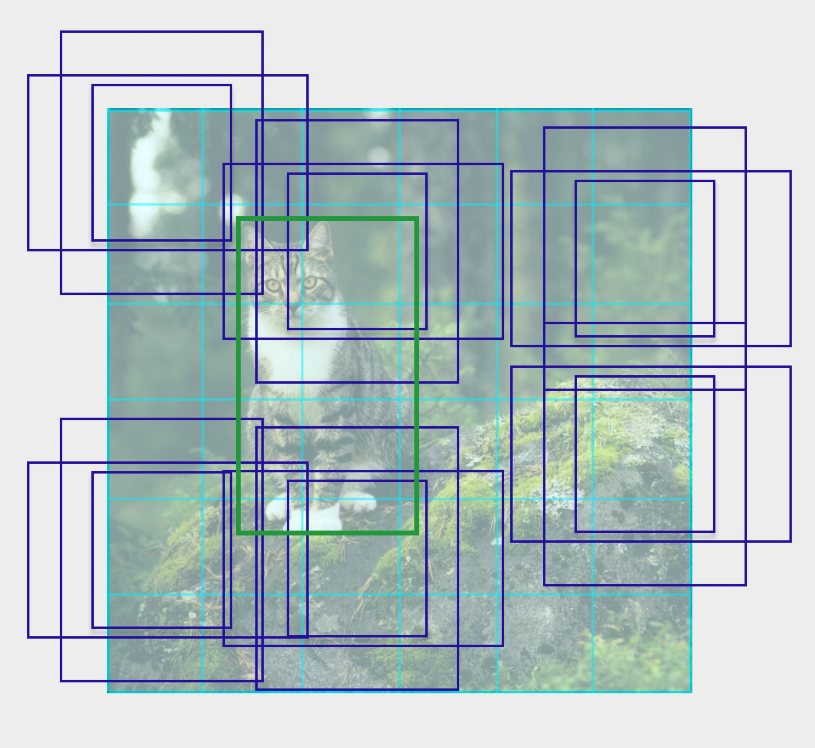

#### Якоря с разных голов как один список:
* https://github.com/fcjian/TOOD/blob/master/mmdet/models/dense_heads/tood_head.py#L702

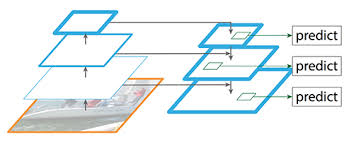

In [112]:
output_anchors = torch.cat(anchors_grids, dim=0)

In [113]:
output_anchors.shape

torch.Size([12000, 4])

#### Якоря с разных голов как как разные объекты:
* YOLO-like архитектуры (4,5,7 точно)

Как решать задачу матчинга между якорями и таргетами? Самый простой - разделить объекты по размерам, чтобы разные головы работали с объектами разного размера.
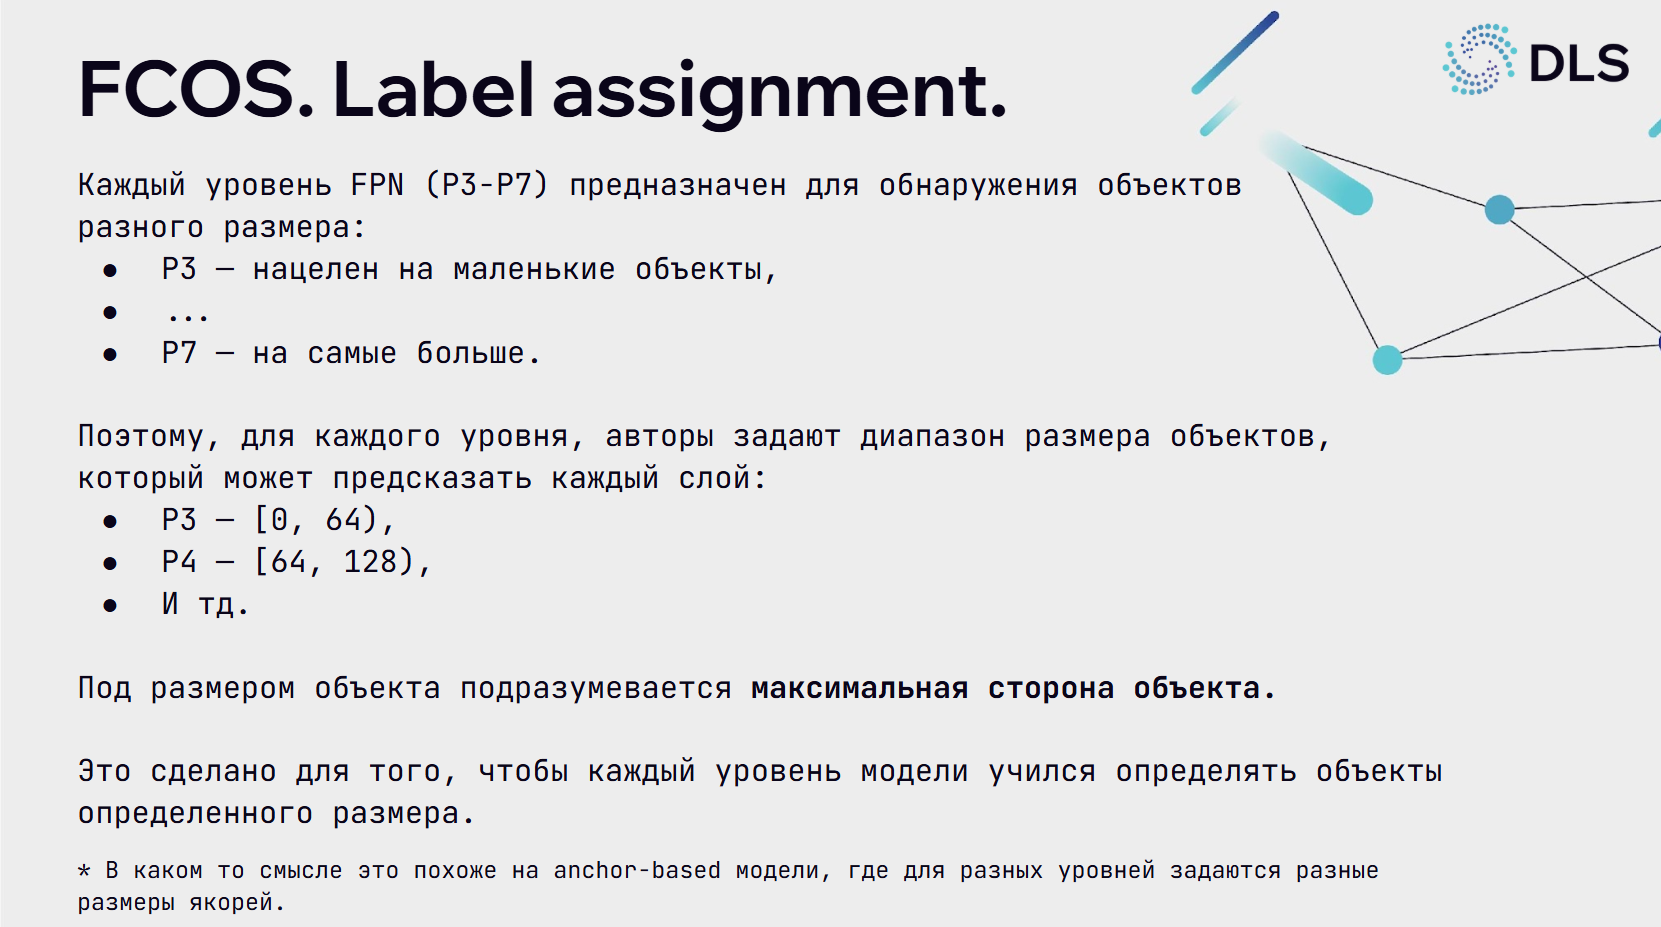

In [ ]:
class Detector(nn.Module):
    def __init__(self, 
                 backbone_model_name="efficientnet_b0",
                 neck_n_channels=256,
                 num_classes=4, 
                 anchor_sizes=((32, 64), (82, 164)),
                 anchor_ratios=((1, 2, 4), (0.5, 1, 2)),
                 input_size=(640, 640),
        ):
        super().__init__()
        self.num_classes = num_classes
        self.backbone = Backbone(backbone_model_name, out_indices=(-1, -2))
        in_channels = self.backbone.backbone.feature_info.channels()[0]
        self.neck = TwoHeadFPN(in_channels, out_channels=neck_n_channels)
        num_anchors = len(anchor_sizes) * len(anchor_ratios)
        
        for anchor_size, anchor_ratio in zip(anchor_sizes, anchor_ratios):
            num_anchors = len(anchor_size) * len(anchor_ratio)
            self.heads.append(DetectionHead(in_channels=neck_n_channels, num_anchors=num_anchors, num_classes=num_classes))

        anchor_generator = AnchorGenerator(sizes=anchor_sizes, aspect_ratios=anchor_ratios)
        reductions = backbone.backbone.feature_info.reduction()[::-1]
        grid_sizes = [
            [input_size[0] // reduction, input_size[1] // reduction]
            for reduction in reductions
        ]
        strides = [[reduction, reduction] for reduction in reductions]
        anchors_grids = ag.grid_anchors(grid_sizes, strides=strides)

        # Дальше псевдокод
        anchor_centers = [(anchors[:, :, :2] + anchors[:, :, 2:]) / 2 for anchors in anchors_grids]
        anchor_sizes = [(anchors[:, :, 2:] - anchors[:, :, :2]), for anchors in anchors_grids]

        self.register_buffer("anchors", anchors_grids)
        self.register_buffer("anchor_centers", anchor_centers)
        self.register_buffer("anchor_sizes", anchor_sizes)

    def forward(self, x):
        features = self.backbone(x)
        neck_features = self.neck(features)
        cls_logits = []
        bbox_offsets = []
        confidences = []

        for neck_feat, head in zip(neck_features, self.heads):
            outputs = head(neck_feat)
            cls_logits.append(outputs[0])
            bbox_offsets.append(outputs[1])
            confidences.append(outputs[2])
        # ТУТ МОЖНО ПЕРЕВЕСТИ bbox_offsets СРАЗУ В bboxes!
        return bbox_offsets, cls_logits, confidences

In [ ]:
def trainer(self, model, ...other_params...):
    for images, targets in train_dataloader:
        bboxes, confs, cls = model(images)

        headwise_predicts = []
        anchors = model.anchors
        for head_anchors, head_params in zip(anchors, any_head_params):
            headwise_predicts.append(target_assignment(head_anchors, head_params))

        loss = compute_loss(targets, headwise_predicts)
        ...

Для удобства вот его основные шаги:

1. Посчитать значение метрики для каждого предсказанного ббокса:
    
$$t = s^\alpha * u^\beta$$
    
где,
* $s$ — classification score, или вероятность принадлежности предсказанного ббокса к классу реального ббокса (**GT**);
* $u$ — IoU между предсказанным и реальным ббоксами;
* $\alpha,\ \beta$ — нормализационные константы, обычно $\alpha = 6.0, \ \beta = 1.0$.
    
2. Отфильтровать предсказания на основе **GT**.

    Для якорных детекторов, обычно, выбираются только те предсказания, центры якорей которых находятся внутри GT.
4. Для каждого **GT** выбрать несколько (обычно 5 или 13) самых подходящих предсказаний.
5. Если предсказание рассматривается в качестве подходящего для нескольких **GT** — выбрать **GT** с наибольшим пересечением по IoU.
